In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import scipy.stats
import statsmodels.stats.multitest
def fast_fisher(p1,p2):
    fisher_stat = -2. * ( np.log(p1) + np.log(p2) )
    return scipy.stats.chi2(df = 4).sf(fisher_stat)

## Meta analyze beta binomial test for HNRNPK

In [4]:
data = [ pd.read_csv("../results/HNRNPK/beta_struct_bblrt_rep%i.tsv.gz" % i, sep = "\t", index_col = False) for i in range(2) ]

In [49]:
data[0].columns

Index(['contig', 'position_hg19', 'variantID', 'refAllele', 'altAllele',
       'position', 'refCount_input', 'altCount_input', 'totalCount_input',
       'pred_ratio', 'refCount_IP', 'altCount_IP', 'totalCount_IP',
       'shrunk_input_logratio', 'ase_loc', 'ase_sd', 'ase_q',
       'shrunk_IP_logratio', 'asb_loc', 'asb_sd', 'asb_q', 'bb_lrt_p'],
      dtype='object')

In [53]:
merged = data[0].merge(data[1], 
                       on = ["contig", "position_hg19", "variantID", "refAllele", "altAllele", "position"],
                      suffixes=["_1","_2"])

In [54]:

#metap = [scipy.stats.combine_pvalues([p1,p2])[1] for p1,p2 in zip(merged.bb_lrt_p_1,merged.bb_lrt_p_2) ]
merged["bblrt_meta_p"] = fast_fisher(merged.bb_lrt_p_1,merged.bb_lrt_p_2)

(0.000779073610652061, 165)

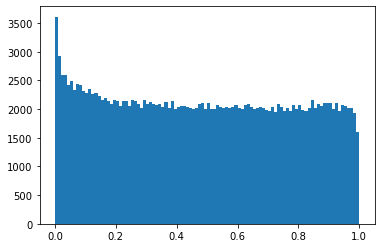

In [55]:
plt.hist(merged.bblrt_meta_p, 100)
_,metaq = statsmodels.stats.multitest.fdrcorrection(merged.bblrt_meta_p)
np.mean(metaq < .2), np.sum(metaq < .2)

(0.00014164974739128383, 30)

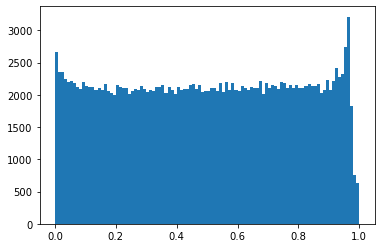

In [42]:
_ = plt.hist(merged.bb_lrt_p_1, 100)
_,q1 = statsmodels.stats.multitest.fdrcorrection(merged.bb_lrt_p_1)
np.mean(q1 < .2), np.sum(q1 < .2)

(0.000259691203550687, 55)

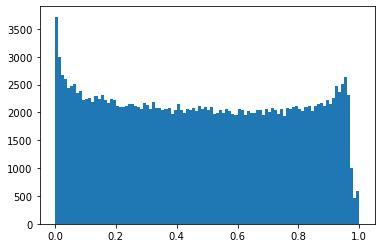

In [44]:
_ = plt.hist(merged.bb_lrt_p_2, 100)
_,q2 = statsmodels.stats.multitest.fdrcorrection(merged.bb_lrt_p_2)
np.mean(q2 < .2), np.sum(q2 < .2)

In [45]:
merged.shape

(211790, 38)

In [46]:
[ g.shape for g in data  ]

[(350637, 22), (246924, 22)]

## Meta analyze beta model

In [76]:
meta_z = merged.asb_loc_1 / merged.asb_sd_1 + merged.asb_loc_2 / merged.asb_sd_2 
meta_z /= np.sqrt(2) # variance=2 because adding 2 independent z-scores (under null)
meta_p = scipy.stats.norm().cdf(-np.abs(meta_z)) 
np.mean(meta_p < 0.01), np.sum(meta_p < 0.01)

(0.009367769960810237, 1984)

In [77]:
meta_loc = merged.asb_loc_1 + merged.asb_loc_2
meta_sd = np.sqrt(merged.asb_sd_1**2 + merged.asb_sd_2**2)
meta_z_2 = meta_loc / meta_sd
meta_p_2 = scipy.stats.norm().cdf(-np.abs(meta_z_2)) # variance=2 because adding 2 independent z-scores (under null)
np.mean(meta_p_2 < 0.01), np.sum(meta_p_2 < 0.01)

(0.008546201425940791, 1810)

In [67]:
np.mean(merged.asb_q_1 < 0.01), np.sum(merged.asb_q_1 < 0.01) 

(0.005566835072477454, 1179)

In [69]:
np.mean(merged.asb_q_2 < 0.01), np.sum(merged.asb_q_2 < 0.01) 

(0.004381698852637046, 928)

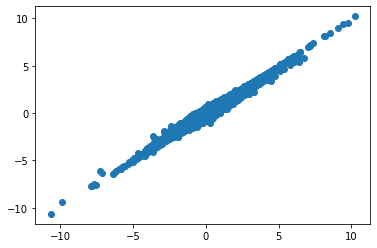

In [75]:
plt.scatter(meta_z, meta_z_2)

Really not much difference but combining z-scores gives slightly more significant so will go with that. 

In [78]:
merged["beta_meta_p"] = meta_p

In [79]:
merged.to_csv("../results/HNRNPK/beta_struct_bblrt_metaan.tsv.gz", index = False, sep = "\t")

In [ ]:
scipy.stats.fisher_exact()

In [89]:
ct = pd.crosstab(meta_p < 0.0005, metaq < .333)
scipy.stats.fisher_exact(ct)

(68.39823692524176, 1.1053820890649077e-65)

In [90]:
scipy.stats.chi2_contingency(ct)

(2418.197539658008,
 0.0,
 1,
 array([[2.10931865e+05, 3.92135285e+02],
        [4.65135285e+02, 8.64715048e-01]]))